# Custom Chatbot Project

### Dataset Choice Explanation

For this project, I have chosen the "Hoofdlijnenakkoord 2024-2028" document, which outlines the coalition agreement between the PVV, VVD, NSC, and BBB political parties in the Netherlands. This document was selected because it provides comprehensive information on policy decisions and political directions that are highly relevant and impactful to the Dutch population.

Since the document is very recent, it contains information that is not available in the current OpenAI GPT models, which were trained before this document was released. This dataset contains structured, textual information divided into main points and sections, making it ideal for augmenting prompts for a custom chatbot designed to answer queries about Dutch political agreements and policies. This domain-specific knowledge ensures that the chatbot can provide accurate and up-to-date responses.

As an experiment, I used Google Translate to translate the document sections into English. I'm curious if this translation makes the content even more accessible to my English-speaking friends and students in Eindhoven. I hope to facilitate better understanding and discussions about Dutch political developments to all beautiful people who live here, no matter where they come from.

In [1]:
%pip install -q pandas pdfplumber openai transformers matplotlib numpy seaborn sentence_transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from openai import OpenAI

# Set the OpenAI API key if not already set in the environment variable
if not os.environ.get('OPENAI_API_KEY'):
	print('Please set the OPENAI_API_KEY environment variable')
	os.environ['OPENAI_API_KEY'] = 'Ya Key Here'

# Initialize the OpenAI API client
client = OpenAI()

## Data Wrangling

### Semantic Chunking
The document is dense with exact details. As an experiment, I performed semantic chunking on the data using SentenceTransformer to split the document into sentences. Cosine similarity is then used to group similar sentences together. These are stored in a dataframe and saved as a CSV file for further processing.

In [3]:
from sentence_transformers import SentenceTransformer, util
import torch
import pandas as pd
import re
import pdfplumber

# no warnings about the model being loaded from cache
import warnings
warnings.filterwarnings("ignore", category=Warning)

# Path to the PDF file and CSV file
pdf_path = 'data/20240515+Hoofdlijnenakkoord+PVV+VVD+NSC+BBB.pdf'
csv_path = 'data/semantic_chunks.csv'

# Initialize the multilingual sentence transformer model
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2', device='cuda' if torch.cuda.is_available() else 'cpu') 

# Function to extract text from PDF using pdfplumber
def extract_text(pdf_path):
	with pdfplumber.open(pdf_path) as pdf:
		text = " ".join(page.extract_text() for page in pdf.pages if page.extract_text())
	return text

# Remove page number pattern and all newlines
def preprocess_text(text):
	text = re.sub(r'\n', ' ', text)  # Remove newlines  
	text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces    
	return text

def split_sentences(text):
	# Split text into sentences
	sentences = re.split(r'(?<!\d)(?<!\d\.\d)\.\s|(?<=\?)\s|(?<=!)\s', text)
	return sentences

# Function to split text into semantically meaningful chunks
def semantic_chunking(sentences, max_chunk_size=700, cos_sim_threshold=0.4):

	# Encode sentences
	sentence_embeddings = model.encode(sentences)
	
	# Cluster sentences into chunks based on cosine similarity
	clusters = []
	
	current_cluster = []
	current_length = 0
	
	for i, sentence in enumerate(sentences):
		sentence = sentence.strip() + '.' if sentence[-1] != '.' else sentence.strip()
		current_cluster.append(sentence)
		current_length += len(sentence)
		
		if current_length >= max_chunk_size or (i < len(sentences) - 1 and util.pytorch_cos_sim(sentence_embeddings[i], sentence_embeddings[i + 1]) < cos_sim_threshold):
			clusters.append(' '.join(current_cluster))
			current_cluster = []
			current_length = 0
	
	return clusters

# only run the code below if the csv file does not exist
try:
	df = pd.read_csv(csv_path)
	print(f'Semantic chunks loaded from {csv_path}')
except FileNotFoundError:
	# Extract and preprocess the text
	pdf_text = extract_text(pdf_path)
	cleaned_text = preprocess_text(pdf_text)

	# Chunk the text semantically
	chunks = semantic_chunking(split_sentences(cleaned_text))

	# Create a DataFrame
	df = pd.DataFrame({'text': chunks})

	# Save to CSV
	df.to_csv(csv_path, index=False)
	print(f'Semantic chunks saved to {csv_path}')
	
df.describe()

/Users/leonvanbokhorst/repos/genai/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Semantic chunks loaded from data/semantic_chunks.csv


,text
count,345
unique,345
top,Subscribe to DeepL Pro to translate larger doc...
freq,1


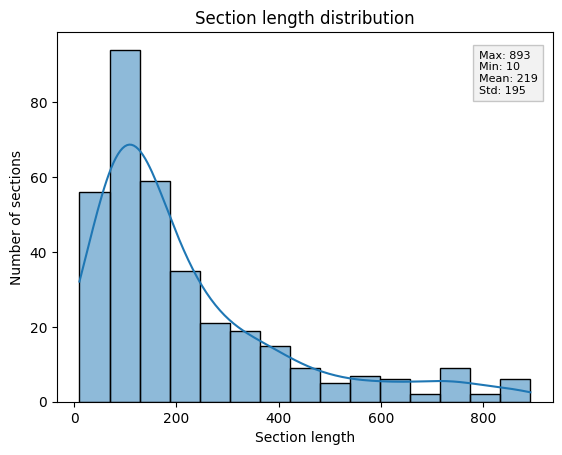

In [4]:
# visualize the length distributions of the sections
import matplotlib.pyplot as plt
import seaborn as sns

df['length'] = df['text'].apply(len)
# calculate the best number of bins for the histogram using the Freedman-Diaconis rule (https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule)
n_bins = int((df['length'].max() - df['length'].min()) / (2 * df['length'].std() * len(df['length']) ** (-1/3)))
sns.histplot(df['length'], kde=True, bins=n_bins)

# print maximum, minimum, and rounded mean and other useful statistic values in plot in a box on the plot
plt.text(0.85, 0.95, f"Max: {df['length'].max()}\nMin: {df['length'].min()}\nMean: {df['length'].mean():.0f}\nStd: {df['length'].std():.0f}", 
	verticalalignment='top', horizontalalignment='right',
	transform=plt.gca().transAxes,
	bbox=dict(facecolor='silver', alpha=0.2), fontsize=8, ha='left')   

plt.xlabel('Section length')
plt.ylabel('Number of sections')
plt.title('Section length distribution')
plt.show()


## Custom Query Completion

In [5]:
# Define the questions
questions = [
	"How many housing units per year need to be build by the government in the Netherlands?",
	"How much can the annual social rental development grow?",
	"What is the title of the Main Line Agreement?"
]

# Define the prompt template for the questions without context
prompts_template = """
Question: {question}
Answer: """

# Construct prompts with the questions and the template
prompts_no_rag = [prompts_template.format(question=question) for question in questions]
	

In [6]:
# Function to generate answers using the OpenAI API
def generate_answer(prompt):
	completion = client.chat.completions.create(
		model="gpt-3.5-turbo",
		messages=[{"role": "user", "content": prompt}],
		stream=False,
		max_tokens=500,
		temperature=0.0,
	)

	return completion.choices[0].message.content

In [7]:
# Generate answers for the questions without context
answers_no_rag = []

for prompt in prompts_no_rag:
	answer = generate_answer(prompt)
	answers_no_rag.append(answer)
	print(answer)

The Dutch government aims to build around 75,000 new housing units per year to address the housing shortage in the country.
The annual social rental development can grow by a certain percentage each year, depending on factors such as demand, funding availability, and government policies. There is no specific limit to how much it can grow annually, as it can vary based on these factors.
The title of the Main Line Agreement is "Agreement on the Establishment of the Main Line of the East African Railways."


### Retrieve OpenAI embeddings each chunk in the dataset


In [8]:
import numpy as np

# Get embeddings from the openai api for each chunk in the dataset
def get_embedding(text:str, model="text-embedding-3-small"):
	text = text.replace('\n', ' ')
	embedding = client.embeddings.create(input = [text], model=model).data[0].embedding
	return np.array(embedding)

In [9]:
import ast

# Path to save the embeddings
path_embeddings_csv = 'data/semantic_chunks_embeddings.csv'
	
# Get embeddings only if the embeddings csv is not already saved
if not os.path.exists(path_embeddings_csv):
    embeddings = [get_embedding(text) for text in df['text']]
    
    df_embeddings = df.copy()
    df_embeddings['embedding'] = embeddings
    df_embeddings['embedding'] = df_embeddings['embedding'].apply(lambda x: ','.join(map(str, x)))  # Flatten the array
    df_embeddings.to_csv(path_embeddings_csv, index=False)

# Function to convert the flattened string back to an array
def str_to_array(x):
    return np.array(list(map(float, x.split(','))))

# Reload the embeddings from the csv file
df_embeddings = pd.read_csv(path_embeddings_csv)
df_embeddings['embedding'] = df_embeddings['embedding'].apply(str_to_array)

df_embeddings.head()

,text,length,embedding
0,Subscribe to DeepL Pro to translate larger doc...,99,"[-0.0267571322619915, -0.037428129464387894, 0..."
1,"HOPE, LEF AND PRIDE - Main Line Agreement 2024...",144,"[-0.04082273319363594, -0.013431457802653313, ..."
2,We have to work hard to earn the trust of the ...,52,"[0.010904844850301743, 0.035049859434366226, 0..."
3,Every day.,10,"[-0.01848646067082882, 0.014253794215619564, 0..."
4,Because trust cannot be taken for granted.,42,"[0.05153677240014076, 0.04500586539506912, -0...."


In [10]:
# Template for prompts with context
prompts_rag_template = """Please take the following important context into account when you answer the users question to the best of your ability. If the question CAN'T be answered based on the context, reply with "I don't know".

Context:

{context}

---
Question: {question}
Answer: """


In [11]:
import numpy as np
import ast

# Get the embedding of the question
def get_most_similar_chunks(question:str, n=3):
	question_embedding = get_embedding(question)
	df_similar_chunks = df_embeddings.copy()
	
	# calculate cosine similarities with pytorch between the question and each chunk
	df_similar_chunks['similarity'] = df_similar_chunks['embedding'].apply(lambda x: util.pytorch_cos_sim(question_embedding, x).item())

	
	# sort the chunks by similarity
	retval = df_similar_chunks.nlargest(n, 'similarity')
	return retval


## Custom Performance Demonstration

In [12]:
# For each question, generate the prompt and get the answer
def generate_answers(questions):
	answers_rag = []
	
	for question in questions:
		most_similar_chunks = get_most_similar_chunks(question, n=10)
		
		context = ''
		for i, row in most_similar_chunks.iterrows():
			context += row['text'] + '\n\n'
		
		prompt = prompts_rag_template.format(context=context, question=question)
    
		answer = generate_answer(prompt)
		answers_rag.append(answer)

	return answers_rag

In [13]:
# print the answers for the first question rag and no_rag
def print_answers(question, answers_rag, answers_no_rag, index=0):
	print(f'Question: {question}')
	print('---')
	print('Answer:')
	print(answers_no_rag[index])
	print('---')
	print('Answer custom query with context:')
	print(answers_rag[index])
	print('---')

In [14]:
# generate answers for the questions with context
answers_rag = generate_answers(questions)

### Question 1

In [15]:
print_answers(questions[0], answers_rag, answers_no_rag, 0)

Question: How many housing units per year need to be build by the government in the Netherlands?
---
Answer:
The Dutch government aims to build around 75,000 new housing units per year to address the housing shortage in the country.
---
Answer custom query with context:
The political goal is to structurally build an additional 100,000 housing units per year in the Netherlands.
---


### Question 2

In [17]:
print_answers(questions[1], answers_rag, answers_no_rag, 1)

Question: How much can the annual social rental development grow?
---
Answer:
The annual social rental development can grow by a certain percentage each year, depending on factors such as demand, funding availability, and government policies. There is no specific limit to how much it can grow annually, as it can vary based on these factors.
---
Answer custom query with context:
The annual social rent development follows the existing agreement with the housing corporations until 2026, namely the CLA development -0.5%.
---


### Question 3

In [18]:
print_answers(questions[2], answers_rag, answers_no_rag, 2)

Question: What is the title of the Main Line Agreement?
---
Answer:
The title of the Main Line Agreement is "Agreement on the Establishment of the Main Line of the East African Railways."
---
Answer custom query with context:
The title of the Main Line Agreement is "HOPE, LEF AND PRIDE - Main Line Agreement 2024 - 2028"
---


In [19]:
# Interactive loop for user input
while True:
    question = input("Please type your question (or type 'exit' to quit): ")
    if question.lower() == 'exit':
        print("Goodbye!")
        break

    # generate answers for the question
    answer = generate_answer(question)
    answer_rag = generate_answers([question])

    # print the answer
    print_answers(question, answer_rag, [answer])


Question: What does BBB stand for?
---
Answer:
BBB stands for Better Business Bureau.
---
Answer custom query with context:
BoerBurgerBeweging
---
Question: Who is WIlders?
---
Answer:
Geert Wilders is a Dutch politician who is the leader of the Party for Freedom (Partij voor de Vrijheid, PVV), a right-wing populist and nationalist political party in the Netherlands. He is known for his controversial views on Islam, immigration, and multiculturalism. Wilders has been a prominent figure in Dutch politics for many years and has been the subject of much debate and criticism both in the Netherlands and internationally.
---
Answer custom query with context:
I don't know.
---
Question: What does NSC stand for?
---
Answer:
NSC stands for National Security Council.
---
Answer custom query with context:
National Security Council
---
Question: How many asilemseekers are allowed in the netherlands according to the agreement?
---
Answer:
According to the agreement between the European Union and Tu